In [1]:
!pip install poetry

In [2]:
!pip install https://github.com/parulsethi/SMorph/releases/download/v0.1.1-alpha/SMorph-0.1.1.tar.gz

In [1]:
import warnings
warnings.filterwarnings('ignore')

import napari
import smorph.util.autocrop as ac

on_colab = 'google.colab' in str(get_ipython())

In [2]:
def view_3D(*args):  # Models a 3D image
    n_images = len(args)
    if not on_colab and n_images > 0:
        with napari.gui_qt():
            viewer = napari.view_image(**args[0])
            for itr in range(1, n_images):
                viewer.add_image(**args[itr])

## 1. Import Confocal Microscopic Image of the Tissue

Set `CONFOCAL_TISSUE_IMAGE` to the path of the image file to be processed.

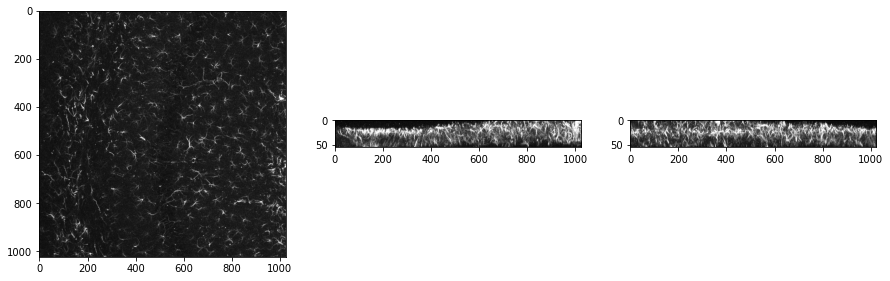

In [4]:
CONFOCAL_TISSUE_IMAGE = 'Datasets/autocrop/C1-M1_LEFT_CA1.tif'

original = ac.import_confocal_image(CONFOCAL_TISSUE_IMAGE)
ac.projectXYZ(original, .5, .5, 1)

## 2. Denoise with Global parameters

### 2.1 Calibrating Denoisers

In [5]:
denoiser = ac.calibrate_nlm_denoiser(original)
denoise_parameters = denoiser.keywords['denoiser_kwargs']
denoise_parameters

{'h': 0.03865602635909908, 'patch_size': 4, 'patch_distance': 3}

### 2.2 Denoise with Non-local means using calibrated parameters

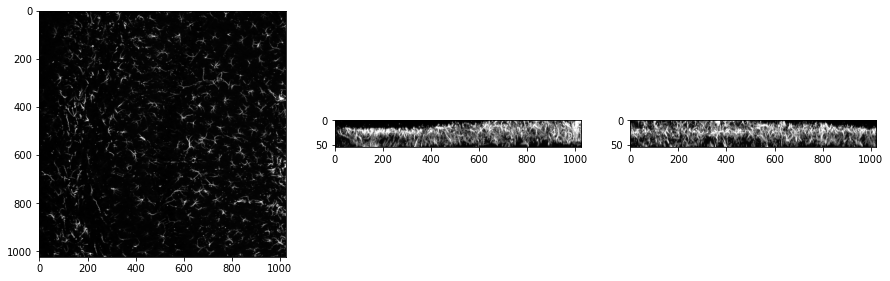

In [6]:
denoised = ac.denoise(original, denoise_parameters)
ac.projectXYZ(denoised, .5, .5, 1)

In [9]:
view_3D({'data': original, 'colormap': 'gray', 'name': 'original'},
        {'data': denoised, 'colormap': 'inferno', 'name': 'denoised'})

## 3. Segmentation

In [8]:
edge_filtered = ac.filter_edges(denoised)  # Edge filtering

### 3.1 Threshold & color label cells

Set two parameters:
- `LOW_THRESH`: Pixel intensity value corresponding to faintest branch's edge
- `HIGH_THRESH`: Pixel intensity value corresponding to faintest soma

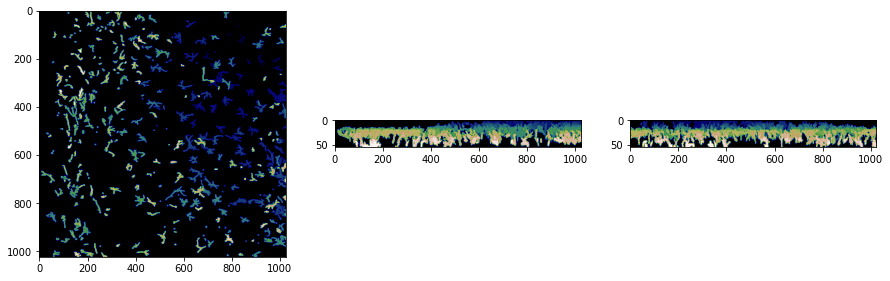

In [22]:
LOW_THRESH = .05
HIGH_THRESH = .45

thresholded = ac.threshold(edge_filtered, LOW_THRESH, HIGH_THRESH)
labels = ac.label_thresholded(thresholded)
ac.projectXYZ(labels, .5, .5, 1, 'gist_earth')

In [23]:
view_3D({'data': original, 'name': 'original'},
        {'data': denoised, 'colormap': 'inferno', 'name': 'denoised'},
        {'data': labels, 'colormap': 'gist_earth', 'gamma': .8, 'name': 'labels'})

### 3.2 Filter segmented individual cells by removing ones in borders (touching the convex hull)

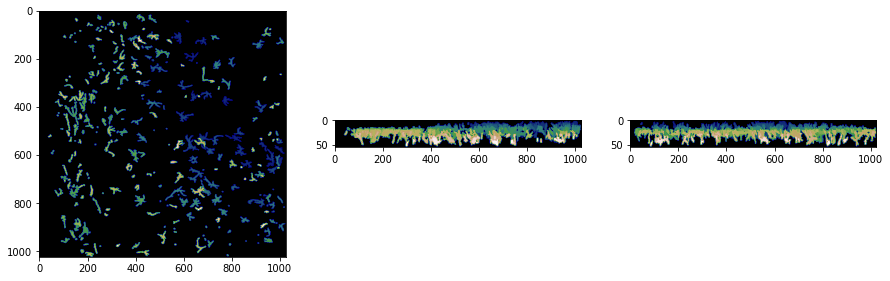

In [24]:
# Find convex hull that approximates tissue structure
convex_hull = ac.compute_convex_hull(thresholded)

# discard objects connected to border of approximated tissue, potential partially captured
filtered_labels = ac.filter_labels(labels, convex_hull)
ac.projectXYZ(filtered_labels, .5, .5, 1, 'gist_earth')

In [25]:
view_3D({'data': filtered_labels, 'name': 'filtered_labels'},
        {'data': labels, 'colormap': 'gist_earth', 'name': 'labels'},
        {'data': convex_hull, 'colormap': 'yellow', 'name': 'convex_hull'})

### 3.3 Visualize segmented cells to determine cutoff volumes

#### 3.3.1 Check batches of objects

In [26]:
regions = ac.arrange_regions(filtered_labels)
N_OBJECTS = len(regions)
print(f'{N_OBJECTS} objects detected.')
N_BATCHES = N_OBJECTS // 50 + (N_OBJECTS % 50 > 0)
print(f'There will be {N_BATCHES} batches, set `BATCH_NO` from 0 to {N_BATCHES-1}')

313 objects detected.
There will be 7 batches, set `BATCH_NO` from 0 to 6


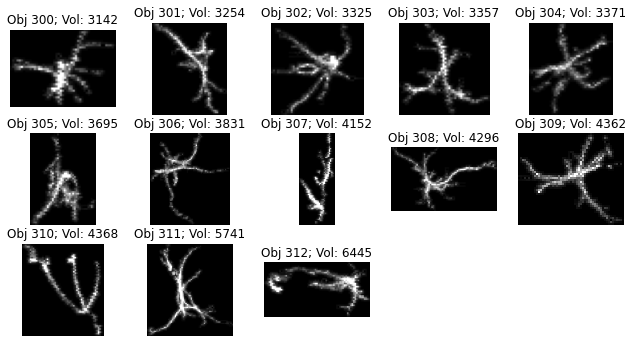

In [35]:
BATCH_NO = 6
ac.project_batch(BATCH_NO, N_BATCHES, N_OBJECTS, regions, denoised)

#### 3.3.2 Check individual objects
Select individual objects using `OBJ_INDEX`.

Volume of cell at index 311 is: 5741


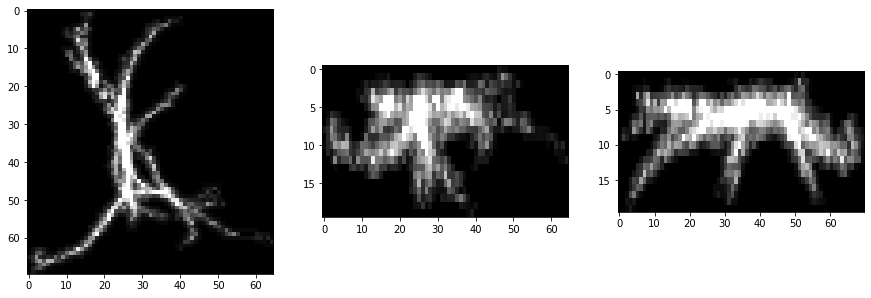

In [36]:
OBJ_INDEX = 311

minz, miny, minx, maxz, maxy, maxx = regions[OBJ_INDEX].bbox

extracted_cell = denoised[minz:maxz, miny:maxy, minx:maxx].copy()
extracted_cell[~regions[OBJ_INDEX].filled_image] = 0.0

print(f'Volume of cell at index {OBJ_INDEX} is: {regions[OBJ_INDEX].area}')
ac.projectXYZ(extracted_cell, .5, .5, 1)

In [37]:
view_3D({'data': denoised[minz:maxz, miny:maxy, minx:maxx], 'name': 'denoised'},
        {'data': regions[OBJ_INDEX].image, 'colormap': 'yellow', 'name': 'thresholded'},
        {'data': extracted_cell, 'colormap': 'inferno', 'name': 'extracted_cell'})

## 4. Export autocropped 3D cells or 2D max intensity projections

Set two parameters:
- `LOW_VOLUME_CUTOFF`: to filter out noise/artifacts
- `HIGH_VOLUME_CUTOFF`: to filter out cell clusters

For choosing between 3D segmented cells or 2D max intensity projections:
- Set `OUTPUT_OPTION` = 0 for 3D cells, or
- Set `OUTPUT_OPTION` = 1 for Max Intensity Projections.

In [38]:
LOW_VOLUME_CUTOFF = 738  # filter noise/artifacts
HIGH_VOLUME_CUTOFF = 5472  # filter cell clusters

OUTPUT_OPTION = 1  # 0 for 3D cells, 1 for Max Intensity Projections

ac.export_cells(CONFOCAL_TISSUE_IMAGE, LOW_VOLUME_CUTOFF, HIGH_VOLUME_CUTOFF, OUTPUT_OPTION, denoised, regions)